In [463]:
import re
import math
import numpy as np
from sortedcontainers import SortedDict
import matplotlib.pyplot as plt
import timeit

In [477]:
#step 1 -> pre process 
def preprocess_chords(data):
    #unpack input into radians and identifiers
    radians, identifiers = data  
    events = []

    #extract 's' or 'e' and the radian value
    pattern = re.compile(r'([se])_?(\d+)')
    for radian, identifier in zip(radians, identifiers):
        match = pattern.match(identifier)
        chord_type, chord_position = match.groups()
        events.append((radian, chord_type, int(chord_position)))

    #sort by radian measure
    events.sort(key=lambda x: x[0])

    return events


#step 2 -> use sweep line to count intersections 
def count_intersections(data, **args):
    events = preprocess_chords(data)
    active_chords = SortedDict()
    intersections = 0

    for radian, chord_type, chord_position in events:
        if chord_type == 's':
            active_chords[chord_position] = radian
        elif chord_type == 'e':
            #remove the start point of the ending chord
            start_radian = active_chords.pop(chord_position)
            
            #check for intersections -> bottle neck that makes time complexity n^2
            for other_start_radian in active_chords.values():
                if start_radian < other_start_radian < radian:
                    intersections += 1

    return intersections



## Visualize

In [499]:
def plot_circle(events, title):
    #make plot
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_aspect('equal')
    
    #plot circle
    circle = plt.Circle((0, 0), 1, edgecolor='black', facecolor='lightcyan')
    ax.add_artist(circle)
    
    #store all points with their radian measures
    points = {}
    for radian, chord_type, chord_position in events:
        points[(chord_type, chord_position)] = radian

    #draw chords by finding matching start and end points
    for (chord_type, chord_position), radian in points.items():
        if chord_type == 's':
            end_key = ('e', chord_position)  #construct end identifier from start identifier
            
            #check if the matching end point exists
            if end_key in points:
                end_radian = points[end_key]
                
                #calculate start and end points for the chord
                start_x, start_y = np.cos(radian), np.sin(radian)
                end_x, end_y = np.cos(end_radian), np.sin(end_radian)
                
                #plot the chord
                ax.plot([start_x, end_x], [start_y, end_y], 'red')

    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_title(title)
    plt.show()
    

## Test

### Basic test cases 

In [500]:
#expected output 0 
test1 = [(1.58, 2.19, 2.31, 4.29, 4.51, 5.2), ('s_5', 's_4', 's_2', 'e_2', 'e_4', 'e_5')] 
#expected output 3
test2 = [(0.1, 1.0, 2.0, 3.0, 4.0, 5.0), ('s_1', 's_2', 's_3', 'e_1', 'e_2', 'e_3')]
#expected output 5
test3 = [(0.019, 0.58, 1.7, 2.27, 3.74, 4.6, 5.74, 6.2), ('s_4', 's_3', 's_1', 's_2', 'e_4', 'e_1', 'e_3', 'e_2')]
#expecetd output 1
test4 = [(0.78, 1.47, 1.77, 3.92),("s_1","s_2","e_1","e_2")]
#expected output 0
test5 = [(0.9, 1.3, 1.70, 2.92),("s1","e1","s2","e2")]

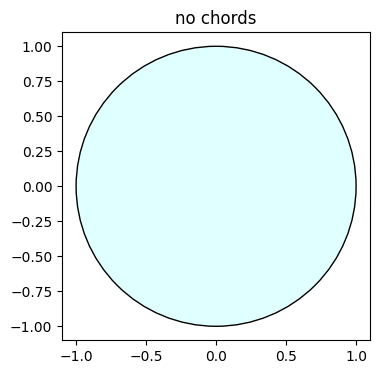

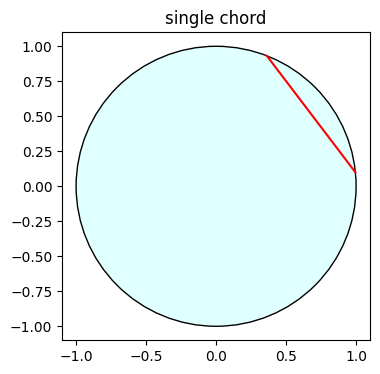

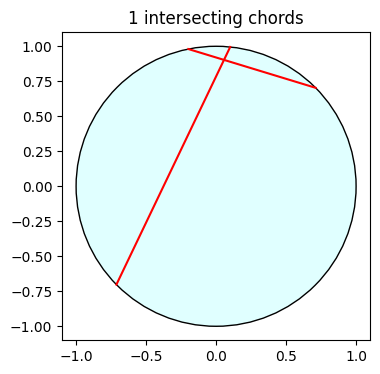

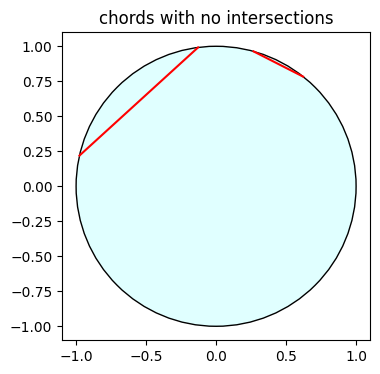

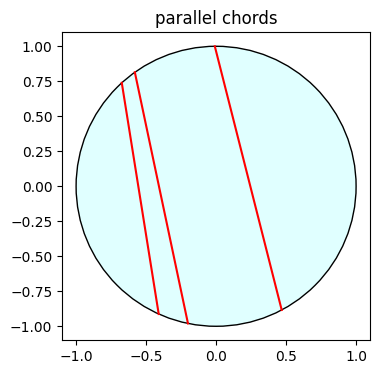

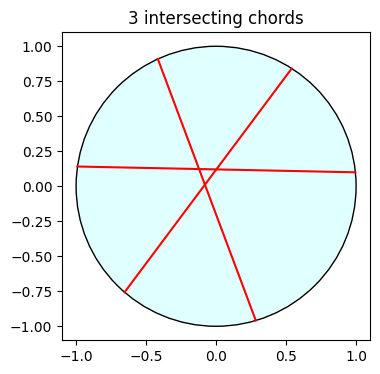

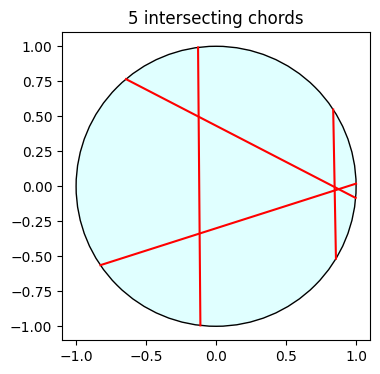

In [501]:
#no chords
plot_circle(preprocess_chords([(),()]), "no chords")
assert count_intersections([measures, identifiers]) == 0, "0 chords fail"

#single chord
plot_circle(preprocess_chords([(0.1, 1.2),('s_1', 'e_1')]), "single chord")
assert count_intersections([measures, identifiers]) == 0, "single chord fail"

#1 intersecting chords
plot_circle(preprocess_chords(test4), "1 intersecting chords")
assert count_intersections(test4)  == 1, "failed 1 chords intersecting"

#chords with no intersections
plot_circle(preprocess_chords(test5),  "chords with no intersections")
assert count_intersections(test5)  == 0, "failed on chords with no intersections"

#parallel
plot_circle(preprocess_chords(test1), "parallel chords")
assert count_intersections([measures,identifiers]) == 0, "failed on parallel chords"

#3 intersecting chords
plot_circle(preprocess_chords(test2), "3 intersecting chords")
assert count_intersections(test2)  == 3, "failed multiple chords intersecting"

#5 intersecting chords
plot_circle(preprocess_chords(test3), "5 intersecting chords")
assert count_intersections(test3)  == 5, "failed multiple chords intersecting"




### Dynamic testing

In [502]:
def generate_test_case(num_chords):
    #random points in range [0,2pi]
    radians = np.random.uniform(0, 2 * np.pi, num_chords * 2)
    identifiers = []
    
    #assign labels, 's' is always before 'e' 
    for i in range(1, num_chords + 1): 
        start_index = (i - 1) * 2
        end_index = start_index + 1
        start_radian = radians[start_index]
        end_radian = radians[end_index]
        
        #swap if end is smaller than start
        if start_radian > end_radian:
            start_radian, end_radian = end_radian, start_radian  
        radians[start_index] = start_radian
        radians[end_index] = end_radian
        identifiers.append(f's{i}')
        identifiers.append(f'e{i}')
    
    #sort measures and keep identifiers matched to sorted measures
    radians, identifiers = zip(*sorted(zip(radians, identifiers)))
    
    return (tuple(radians), tuple(identifiers))

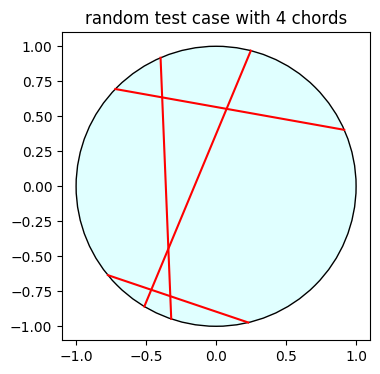

The number of intersections is 5


In [503]:
n = 4
random_test = generate_test_case(n)
plot_circle(preprocess_chords(random_test), f'random test case with {n} chords')
print(f'The number of intersections is {count_intersections(random_test)}')

## Time Complexity Analysis

In [504]:
def measure_execution_time(func, *args):
    #mesure how long execution of a given function takes
    start_time = timeit.default_timer()
    func(*args)
    end_time = timeit.default_timer()
    return end_time - start_time

In [505]:
def experiment_runtime(num_chords_list, function, trials):
    avg_runtime_dict = {n: 0 for n in num_chords_list}

    for i in range(trials):
        #run an experiment
        for num_chords in num_chords_list:
            chord_data = generate_test_case(num_chords)
            execution_time = measure_execution_time(function, chord_data)

            #accumulate execution times
            avg_runtime_dict[num_chords] += execution_time
            
    avg_execution_times = [avg_runtime_dict[n] / trials for n in num_chords_list]

    return avg_execution_times

In [495]:
num_chords_list = np.linspace(2, 1000, 100, dtype=int)
n2_times = [n**2 for n in num_chords_list]
max_theoretical_time = max(n2_times)


In [496]:
avg_execution_times_sl = experiment_runtime(num_chords_list, count_intersections, trials = 10)
max_empirical_time_sl = max(avg_execution_times_sl)  
n2_times_normalized_sl = [time * (max_empirical_time_sl / max_theoretical_time) for time in n2_times]  # Corrected variable name


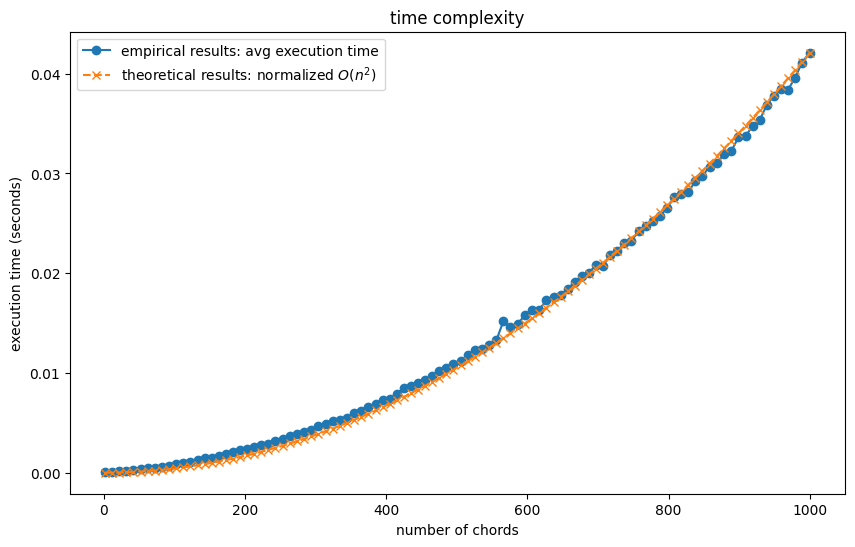

In [498]:
plt.figure(figsize=(10, 6))
plt.plot(num_chords_list, avg_execution_times_sl, marker='o', label='empirical results: avg execution time')
plt.plot(num_chords_list, n2_times_normalized_sl, marker='x', linestyle='--', label='theoretical results: normalized $O(n^2)$')
plt.xlabel('number of chords')
plt.ylabel('execution time (seconds)')
plt.title('time complexity')
plt.legend()
plt.show()